## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

This notebook assumes you have completed the steps on https://teaching-on-testbeds.github.io/hello-chameleon/ and have uploaded the neccessary public key on the "key pairs" tab on the KVM@TACC site 

### Configure environment

In [1]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [2]:
chi.use_site("KVM@TACC")
PROJECT_NAME = "CHI-231138"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


Now using KVM@TACC:
URL: https://kvm.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need three virtual machines connected to a common network. Each of the virtual machines will be of the `m1.large` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [3]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu24.04', 'packages': ["python3", "virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu24.04', 'packages': ["python3", "virtualenv"], 'bastion': False}, 
 {'name': "node-2",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu24.04', 'packages': ["python3", "virtualenv"], 'bastion': False} 
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}]},
]
route_conf = []

### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [4]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

Next, we will prepare the “experiment” networks -

In [5]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [6]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

We wait for all servers to come up before we proceed -

In [7]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [8]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

{'network_id': '68f045f5-61c2-4cb3-bafd-5f4af290d707',
 'tenant_id': '13a1ac1ce275484caedc3394339486a1',
 'subnet_id': 'e6344942-27ba-4e42-8b0a-e6944190cae3',
 'subnet_ids': ['e6344942-27ba-4e42-8b0a-e6944190cae3'],
 'port_id': 'a1632879-676c-4618-b539-96ed0a999812',
 'id': '4fc71a9c-bf8d-4fa0-a48d-37f02c5d296e'}

In [9]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = []
for i, n in enumerate(node_conf):
    if 'bastion' in n and n['bastion']:
        ip = chi.server.associate_floating_ip(server_ids[i])
        server_ips.append(ip)

In [10]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [11]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [12]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

Finally, we need to configure our resources, including software package installation and network configuration.

In [13]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    # these are required for ray
    remote.run(f"sudo firewall-cmd --permanent --add-port=6379/tcp")
    remote.run(f"sudo firewall-cmd --permanent --add-port=8265/tcp")
    remote.run(f"sudo firewall-cmd --reload")

    time.sleep(3)

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.25.225: b'e667e72cdb86ed4c2c6a6a568cbb81c0'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'e667e72cdb86ed4c2c6a6a568cbb81c0'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'7f22341d73c0107eb1ee160f9f142cad'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'027bb7711c6e1a47411e6d54251eaf50'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success
success
success
success


In [14]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:2 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:5 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [586 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/main amd64 Packages [775 kB]
Get:7 http://security.ubuntu.com/ubuntu noble-security/main amd64 Components [7268 B]
Get:8 http://security.ubuntu.com/ubuntu noble-security/main amd64 c-n-f Metadata [5892 B]
Get:9 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [800 kB]
Get:10 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Components [52.0 kB]
Get:11 http://security.ubuntu.com/ubuntu noble-security/universe amd64 c-n-f Metadata [13.5 kB]
Get:12 http://security.ubuntu.com/ubuntu noble-sec

Reading package lists...
Building dependency tree...
Reading state information...
python3 is already the newest version (3.12.3-0ubuntu2).
python3 set to manually installed.
The following additional packages will be installed:
  python3-distlib python3-filelock python3-platformdirs python3-virtualenv
  python3-wheel-whl
Recommended packages:
  python3-distutils
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-platformdirs python3-virtualenv
  python3-wheel-whl virtualenv
0 upgraded, 6 newly installed, 0 to remove and 102 not upgraded.
Need to get 486 kB of archives.
After this operation, 1796 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu noble/universe amd64 python3-distlib all 0.3.8-1 [318 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu noble/universe amd64 python3-filelock all 3.13.1-1 [10.8 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu noble/main amd64 python3-platformdirs all 4.2.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 486 kB in 0s (1222 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 89422 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.8-1_all.deb ...
Unpacking python3-distlib (0.3.8-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.13.1-1_all.deb ...
Unpacking python3-filelock (3.13.1-1) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../2-python3-platformdirs_4.2.0-1_all.deb ...
Unpacking python3-platformdirs (4.2.0-1) ...
Selecting previously unselected package python3-wheel-whl.
Preparing to unpack .../3-python3-wheel-whl_0.42.0-2_all.deb ...
Unpacking python3-wheel-whl (0.42.0-2) ...
Selecting previously unselected package python3-virtualenv.
Preparing to unpack .../4-python3-virtualenv_20.25.0+ds-2_all.deb ...
Unpacking python3-virtualenv (20.25.0+ds-2) ...
Selecting previously unselected package virtualenv.
P

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.




Get:1 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:3 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [586 kB]
Get:4 http://security.ubuntu.com/ubuntu noble-security/main amd64 Components [7220 B]
Get:5 http://security.ubuntu.com/ubuntu noble-security/main amd64 c-n-f Metadata [5892 B]
Get:6 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [800 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:8 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Components [52.0 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/universe amd64 c-n-f Metadata [13.5 kB]
Get:10 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Packages [572 kB]
Get:11 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Components [212 B]
Get:12 http://security.ubuntu.com/ubuntu noble-se

Reading package lists...
Building dependency tree...
Reading state information...
python3 is already the newest version (3.12.3-0ubuntu2).
python3 set to manually installed.
The following additional packages will be installed:
  python3-distlib python3-filelock python3-platformdirs python3-virtualenv
  python3-wheel-whl
Recommended packages:
  python3-distutils
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-platformdirs python3-virtualenv
  python3-wheel-whl virtualenv
0 upgraded, 6 newly installed, 0 to remove and 102 not upgraded.
Need to get 486 kB of archives.
After this operation, 1796 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu noble/universe amd64 python3-distlib all 0.3.8-1 [318 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu noble/universe amd64 python3-filelock all 3.13.1-1 [10.8 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu noble/main amd64 python3-platformdirs all 4.2.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 486 kB in 1s (424 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 89422 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.8-1_all.deb ...
Unpacking python3-distlib (0.3.8-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.13.1-1_all.deb ...
Unpacking python3-filelock (3.13.1-1) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../2-python3-platformdirs_4.2.0-1_all.deb ...
Unpacking python3-platformdirs (4.2.0-1) ...
Selecting previously unselected package python3-wheel-whl.
Preparing to unpack .../3-python3-wheel-whl_0.42.0-2_all.deb ...
Unpacking python3-wheel-whl (0.42.0-2) ...
Selecting previously unselected package python3-virtualenv.
Preparing to unpack .../4-python3-virtualenv_20.25.0+ds-2_all.deb ...
Unpacking python3-virtualenv (20.25.0+ds-2) ...
Selecting previously unselected package virtualenv.
Pr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.




Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:2 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/main amd64 Packages [775 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/main amd64 Components [151 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/main amd64 c-n-f Metadata [10.4 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/universe amd64 Packages [974 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [586 kB]
Get:10 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/universe amd64 Components [310 kB]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu noble-updates/universe amd64 c-n-f Metadata [19.9 kB]


Reading package lists...
Building dependency tree...
Reading state information...
python3 is already the newest version (3.12.3-0ubuntu2).
python3 set to manually installed.
The following additional packages will be installed:
  python3-distlib python3-filelock python3-platformdirs python3-virtualenv
  python3-wheel-whl
Recommended packages:
  python3-distutils
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-platformdirs python3-virtualenv
  python3-wheel-whl virtualenv
0 upgraded, 6 newly installed, 0 to remove and 102 not upgraded.
Need to get 486 kB of archives.
After this operation, 1796 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu noble/universe amd64 python3-distlib all 0.3.8-1 [318 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu noble/universe amd64 python3-filelock all 3.13.1-1 [10.8 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu noble/main amd64 python3-platformdirs all 4.2.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 486 kB in 0s (1215 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 89422 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.8-1_all.deb ...
Unpacking python3-distlib (0.3.8-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.13.1-1_all.deb ...
Unpacking python3-filelock (3.13.1-1) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../2-python3-platformdirs_4.2.0-1_all.deb ...
Unpacking python3-platformdirs (4.2.0-1) ...
Selecting previously unselected package python3-wheel-whl.
Preparing to unpack .../3-python3-wheel-whl_0.42.0-2_all.deb ...
Unpacking python3-wheel-whl (0.42.0-2) ...
Selecting previously unselected package python3-virtualenv.
Preparing to unpack .../4-python3-virtualenv_20.25.0+ds-2_all.deb ...
Unpacking python3-virtualenv (20.25.0+ds-2) ...
Selecting previously unselected package virtualenv.
P

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.


In [15]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

In [16]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 8265"):
    os_conn.create_security_group("Allow HTTP 8265", "Enable HTTP traffic on TCP port 8265")
    os_conn.create_security_group_rule("Allow HTTP 8265", port_range_min=8265, port_range_max=8265, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 8265").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [17]:
!pip install networkx

In [18]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

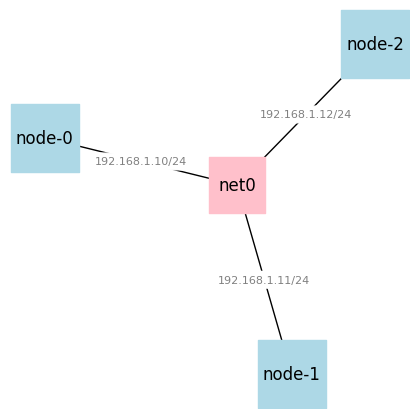

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Start the Ray Cluster

Now that we have the network set up it is time for us to start the ray cluster. For this we need to select a head node and te wo worker nodes. In our case we have node-0 set up as the bastion node and we will use the same as the head node.

In [20]:
remote = chi.ssh.Remote(server_ips[0])

In [21]:
# make sure "head" node can SSH into the others
remote.run('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key = remote.run('cat ~/.ssh/id_rsa.pub').tail("stdout")[2:]

for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run(f'echo {public_key} >> ~/.ssh/authorized_keys') 

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.25.225: b'e667e72cdb86ed4c2c6a6a568cbb81c0'
  warnings.warn(


ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDEBlpD9oyp8Zx0zPsWvnsI/bQC5IClyTuyxv00v0LWzy8EODNeHMqbiLnDcBGfLFS+4STooNqZwvTQJnDNUYo3QYsO/Lw2MIFuHJo3E9toOwAoN0qPt8oPfqykYKT6OiWoWLG93sjslltoe10LXP/v49tM6JIxvAc6wg3sIvVfOUoSByasJCnof02wxZxYWY/MHcrxBWqBLova7HJVHt1OP800zIlCvul6F2M8OcH5xNWGwQedAgenWiedeNqCrLJpdlg0tm88qXcBEZjzQFgT1WBboEHm2RvoUVFzYotB8RQbmE2cQ02u5+IhGgKvlvOV5SHRxOppFVXM8+4v43vStbIgqTaE2rcAdQacoHa5D9f8d+tO33OQF44K7Gq2HUIKPXyvI72IECdMA89P+BPRZno9b5XQJvmuJE339/mnMGNuBQUJqAaXMeyu4mdHyXT//sUBQixSOxLznxkc2jwIcjijdDC2YG50M8x6x3KblAUqM0SXXEvP+dk7+vcAdUNBelwyHE9uunp1V9MHLy9t0tSWTpha+bRL58BEvn0vYiPyFt0gvFGTHqXi2Kvf/E4Wda4Ux8ZQLhls/AOCWJop1skXRH4FmNQneV3jhYHtOBAW2fWAyXDRWiPKbAoLeKPcG5TSDFL9WvmMaFYZ1Pajk5JbP6bQSuDIs7moCuJtJw== cc@node-0-vrj2006-nyu-edu


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'e667e72cdb86ed4c2c6a6a568cbb81c0'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'7f22341d73c0107eb1ee160f9f142cad'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'027bb7711c6e1a47411e6d54251eaf50'
  warnings.warn(


### Get SSH login details

At this point, we should be able to log in to our head node over SSH! Run the following cell, and observe the output - you will see SSH command for the head node using the public ip.

In [22]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.25.225


Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to the node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)

For example ssh -i ~/.ssh/id_rsa_chameleon cc@public_ip

Now on node-0 run the following command to install ray using a virtual environment and set it up as the head node and check the status of the ray cluster:

In [23]:
remote.run("virtualenv -p python3 myenv")
remote.run("source myenv/bin/activate; pip3 install scikit-learn; pip3 install -U 'ray[default, tune]'; pip install bayesian-optimization==1.5.1")
remote.run("source myenv/bin/activate; ray start --head --node-ip-address='192.168.1.10' --dashboard-host='0.0.0.0' --port='6379'; ray status")

created virtual environment CPython3.12.3.final.0-64 in 728ms
  creator CPython3Posix(dest=/home/cc/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/home/cc/.local/share/virtualenv)
    added seed packages: pip==24.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<Result cmd="source myenv/bin/activate; ray start --head --node-ip-address='192.168.1.10' --dashboard-host='0.0.0.0' --port='6379'; ray status" exited=0>

This will set node-0 as the  "head" and allow ray to listen on port 6379 on node-0, the dashboard for ray will be accessible via the public ip at port 8265. To access the ray dashboard copy the url from the following code block and paste it in your local browser. 

In [24]:
print(f"http://{server_ips[0]}:8265")

http://129.114.25.225:8265


Next we want to connect the worker nodes to the cluster. 

On node-1 and node-2 run:

In [26]:
# add the worker nodes to the  ray cluster on all other nodes run
for physical_ip in physical_ips[1:]:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("virtualenv -p python3 myenv")
    remote_worker.run("source myenv/bin/activate; pip3 install scikit-learn; pip3 install -U 'ray[default, tune]';pip install bayesian-optimization==1.5.1")
    remote_worker.run("source myenv/bin/activate; ray start --address='192.168.1.10:6379'")

created virtual environment CPython3.12.3.final.0-64 in 507ms
  creator CPython3Posix(dest=/home/cc/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/home/cc/.local/share/virtualenv)
    added seed packages: pip==24.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 482.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[2025-01-20 11:37:24,548 W 2187 2187] global_state_accessor.cc:463: Retrying to get node with node ID b046648afa41812f2efe8db9155f0f2405309a09016a9f8e527f28f0


2025-01-20 11:37:24,479	INFO scripts.py:1005 -- Local node IP: 192.168.1.11
2025-01-20 11:37:25,555	SUCC scripts.py:1018 -- --------------------
2025-01-20 11:37:25,555	SUCC scripts.py:1019 -- Ray runtime started.
2025-01-20 11:37:25,556	SUCC scripts.py:1020 -- --------------------
2025-01-20 11:37:25,556	INFO scripts.py:1022 -- To terminate the Ray runtime, run
2025-01-20 11:37:25,557	INFO scripts.py:1023 --   ray stop
created virtual environment CPython3.12.3.final.0-64 in 672ms
  creator CPython3Posix(dest=/home/cc/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/home/cc/.local/share/virtualenv)
    added seed packages: pip==24.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━

[2025-01-20 11:38:44,580 W 2166 2166] global_state_accessor.cc:463: Retrying to get node with node ID 5b4ef0b611c40d4d453b67163ae072bc480138643c54e6b25c123a8c


2025-01-20 11:38:44,500	INFO scripts.py:1005 -- Local node IP: 192.168.1.12
2025-01-20 11:38:45,587	SUCC scripts.py:1018 -- --------------------
2025-01-20 11:38:45,588	SUCC scripts.py:1019 -- Ray runtime started.
2025-01-20 11:38:45,588	SUCC scripts.py:1020 -- --------------------
2025-01-20 11:38:45,589	INFO scripts.py:1022 -- To terminate the Ray runtime, run
2025-01-20 11:38:45,589	INFO scripts.py:1023 --   ray stop


On each system you should see the output:

Ray runtime started.

To terminate the Ray runtime, run
 
 ray stop

Now you should have successfully connected the worker nodes to the head node and have an active ray cluster up and running.

To make sure that the cluster has been set up correctly navigate to the cluster tab on the ray dashboard on your local browser using the link below and observe that the cluster has three nodes in the "ALIVE" state with one node as the (Head)

In [27]:
print(f"http://{server_ips[0]}:8265")

http://129.114.25.225:8265


In [28]:
#To check if ray is running correctly
remote.run("source myenv/bin/activate; ray status")
for physical_ip in physical_ips[1:]:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("source myenv/bin/activate; ray status")
    
    

======== Autoscaler status: 2025-01-20 11:38:44.131020 ========
Node status
---------------------------------------------------------------
Active:
 1 node_85c2f3c964d0ec2f607413287d9045027ff326c1fd107a78bccaabf1
 1 node_b046648afa41812f2efe8db9155f0f2405309a09016a9f8e527f28f0
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 0.0/4.0 CPU
 0B/4.49GiB memory
 0B/2.07GiB object_store_memory

Demands:
 (no resource demands)
======== Autoscaler status: 2025-01-20 11:38:49.138906 ========
Node status
---------------------------------------------------------------
Active:
 1 node_5b4ef0b611c40d4d453b67163ae072bc480138643c54e6b25c123a8c
 1 node_85c2f3c964d0ec2f607413287d9045027ff326c1fd107a78bccaabf1
 1 node_b046648afa41812f2efe8db9155f0f2405309a09016a9f8e527f28f0
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usa

### Experiments

In this experiment, we will perform distributed hyperparameter optimization for training a Support Vector Machine (SVM) on the Digits dataset using Ray Tune, a scalable framework for distributed machine learning tasks. The goal is to identify the optimal hyperparameters for the SVM model to maximize classification accuracy on a validation set.

In [29]:
# clone repository containing ray experiments on head nod-0
remote.run("git clone https://github.com/virjhangianinyu/ray-cluster-experiments.git")

Cloning into 'ray-cluster-experiments'...


<Result cmd='git clone https://github.com/virjhangianinyu/ray-cluster-experiments.git' exited=0>

In [31]:
remote.run("source myenv/bin/activate; python3 ray-cluster-experiments/svm_experiments/svm_hyperparameter_opt.py")

2025-01-20 11:56:00,571	INFO worker.py:1636 -- Connecting to existing Ray cluster at address: 192.168.1.10:6379...
2025-01-20 11:56:00,588	INFO worker.py:1812 -- Connected to Ray cluster. View the dashboard at http://192.168.1.10:8265 


Running Grid Search...
╭────────────────────────────────────────────────────────╮
│ Configuration for experiment     grid_search_digits    │
├────────────────────────────────────────────────────────┤
│ Search algorithm                 BasicVariantGenerator │
│ Scheduler                        FIFOScheduler         │
│ Number of trials                 18                    │
╰────────────────────────────────────────────────────────╯

View detailed results here: /home/cc/ray-cluster-experiments/ray_results/grid_search_digits
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-20_11-35-22_591995_2167/artifacts/2025-01-20_11-56-00/grid_search_digits/driver_artifacts`

Trial status: 18 PENDING
Current time: 2025-01-20 11:56:01. Total running time: 0s
Logical resource usage: 0/6 CPUs, 0/0 GPUs
╭──────────────────────────────────────────────────────────────╮
│ Trial name              status     kernel        C     gamma │
├──────────────────────────

2025-01-20 11:56:16,355	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/cc/ray-cluster-experiments/ray_results/grid_search_digits' in 0.0276s.


╭───────────────────────────────────────────────╮
│ Trial svm_train_845eb_00013 result            │
├───────────────────────────────────────────────┤
│ checkpoint_dir_name                           │
│ time_this_iter_s                       0.3649 │
│ time_total_s                           0.3649 │
│ training_iteration                          1 │
│ accuracy                                 0.95 │
╰───────────────────────────────────────────────╯

Trial svm_train_845eb_00012 completed after 1 iterations at 2025-01-20 11:56:13. Total running time: 13s
╭────────────────────────────────────────────────╮
│ Trial svm_train_845eb_00012 result             │
├────────────────────────────────────────────────┤
│ checkpoint_dir_name                            │
│ time_this_iter_s                       0.33512 │
│ time_total_s                           0.33512 │
│ training_iteration                           1 │
│ accuracy                               0.35278 │
╰───────────────────────────────────

2025-01-20 11:56:55,092	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/cc/ray-cluster-experiments/ray_results/random_search_digits' in 0.0453s.


╭────────────────────────────────────────────────╮
│ Trial svm_train_8dc82_00048 result             │
├────────────────────────────────────────────────┤
│ checkpoint_dir_name                            │
│ time_this_iter_s                       0.40179 │
│ time_total_s                           0.40179 │
│ training_iteration                           1 │
│ accuracy                               0.38611 │
╰────────────────────────────────────────────────╯

Trial status: 50 TERMINATED
Current time: 2025-01-20 11:56:55. Total running time: 38s
Logical resource usage: 1.0/6 CPUs, 0/0 GPUs
Current best trial: 8dc82_00001 with accuracy=0.9777777777777777 and params={'kernel': 'rbf', 'C': 1.3265503593511532, 'gamma': 0.023372935360476577}
╭───────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Trial name              status       kernel            C       gamma     iter     total time (s)     accuracy │
├─────────────────────────────

2025-01-20 11:56:55,186	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.
2025-01-20 11:56:55,186	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.


{'kernel': 'rbf', 'C': 1.3265503593511532, 'gamma': 0.023372935360476577}

Running Bayesian Optimization...
╭────────────────────────────────────────────────────╮
│ Configuration for experiment     bayesopt_digits   │
├────────────────────────────────────────────────────┤
│ Search algorithm                 SearchGenerator   │
│ Scheduler                        FIFOScheduler     │
│ Number of trials                 50                │
╰────────────────────────────────────────────────────╯

View detailed results here: /home/cc/ray-cluster-experiments/ray_results/bayesopt_digits
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-20_11-35-22_591995_2167/artifacts/2025-01-20_11-56-55/bayesopt_digits/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-01-20 11:56:55. Total running time: 0s
Logical resource usage: 0/6 CPUs, 0/0 GPUs
╭────────────────────────────────────────────────────╮
│ Trial name           status           C      gamma

2025-01-20 11:57:27,603	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(9.033771568189866), 'gamma': np.float64(0.01)}.
2025-01-20 11:57:27,776	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(9.033771670968608), 'gamma': np.float64(0.01)}.


╭─────────────────────────────────────────────╮
│ Trial svm_train_fbd6dcb9 result             │
├─────────────────────────────────────────────┤
│ checkpoint_dir_name                         │
│ time_this_iter_s                    0.37244 │
│ time_total_s                        0.37244 │
│ training_iteration                        1 │
│ accuracy                            0.66389 │
╰─────────────────────────────────────────────╯

Trial status: 10 TERMINATED | 1 PENDING
Current time: 2025-01-20 11:57:25. Total running time: 30s
Logical resource usage: 1.0/6 CPUs, 0/0 GPUs
╭────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Trial name           status              C      gamma     iter     total time (s)     accuracy │
├────────────────────────────────────────────────────────────────────────────────────────────────┤
│ svm_train_e69b077b   TERMINATED   3.80795    0.951207        1           0.536043    0.0805556 │
│ svm_train_6636e94b   TERM

2025-01-20 11:58:03,762	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(0.1), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:04,031	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(0.1), 'gamma': np.float64(0.01)}.


╭─────────────────────────────────────────────╮
│ Trial svm_train_fc654cd9 config             │
├─────────────────────────────────────────────┤
│ C                                   5.03339 │
│ gamma                               0.61303 │
╰─────────────────────────────────────────────╯

Trial svm_train_fc654cd9 completed after 1 iterations at 2025-01-20 11:57:55. Total running time: 59s
╭─────────────────────────────────────────────╮
│ Trial svm_train_fc654cd9 result             │
├───────────────────────────────────────���─────┤
│ checkpoint_dir_name                         │
│ time_this_iter_s                    0.41505 │
│ time_total_s                        0.41505 │
│ training_iteration                        1 │
│ accuracy                            0.21944 │
╰─────────────────────────────────────────────╯

Trial status: 20 TERMINATED | 1 PENDING
Current time: 2025-01-20 11:57:55. Total running time: 1min 0s
Logical resource usage: 1.0/6 CPUs, 0/0 GPUs
╭─────────────────────────

2025-01-20 11:58:07,476	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(0.8224096631106543), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:07,673	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(0.8224093643269147), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:10,666	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(2.4385417309179105), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:10,893	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(2.438541865507156), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:14,180	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(3.846787236942745), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:14,456	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(3.8467887431459085), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:17,310	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(7.928854

╭─────────────────────────────────────────────╮
│ Trial svm_train_01d443bb config             │
├─────────────────────────────────────────────┤
│ C                                   0.82241 │
│ gamma                                  0.01 │
╰─────────────────────────────────────────────╯

Trial svm_train_01d443bb completed after 1 iterations at 2025-01-20 11:58:07. Total running time: 1min 12s
╭─────────────────────────────────────────────╮
│ Trial svm_train_01d443bb result             │
├─────────────────────────────────────��───────┤
│ checkpoint_dir_name                         │
│ time_this_iter_s                    0.11436 │
│ time_total_s                        0.11436 │
│ training_iteration                        1 │
│ accuracy                            0.98333 │
╰─────────────────────────────────────────────╯

Trial svm_train_2515ce75 started with configuration:
╭─────────────────────────────────────────────╮
│ Trial svm_train_2515ce75 config             │
├────────────────────

2025-01-20 11:58:58,172	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(6.222938323817687), 'gamma': np.float64(0.01)}.
2025-01-20 11:58:58,433	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(6.222937924480545), 'gamma': np.float64(0.01)}.
2025-01-20 11:59:01,381	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(2.8174764714221356), 'gamma': np.float64(0.01)}.
2025-01-20 11:59:01,609	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(2.817476099992409), 'gamma': np.float64(0.01)}.
2025-01-20 11:59:04,996	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(0.45619037150001573), 'gamma': np.float64(0.01)}.
2025-01-20 11:59:05,266	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(0.4561917717900698), 'gamma': np.float64(0.01)}.


Trial svm_train_6525d1d9 started with configuration:
╭─────────────────────────────────────────────╮
│ Trial svm_train_6525d1d9 config             │
├─────────────────────────────────────────────┤
│ C                                   3.17733 │
│ gamma                                  0.01 │
╰─────────────────────────────────────────────╯

Trial svm_train_6525d1d9 completed after 1 iterations at 2025-01-20 11:58:54. Total running time: 1min 59s
╭─────────────────────────────────────────────╮
│ Trial svm_train_6525d1d9 result             │
├─────────────────────────────────────────────┤
│ checkpoint_dir_name                         │
│ time_this_iter_s                    0.10346 │
│ time_total_s                        0.10346 │
│ training_iteration                        1 │
│ accuracy                            0.98611 │
╰─────────────────────────────────────────────╯

Trial status: 39 TERMINATED | 1 PENDING
Current time: 2025-01-20 11:58:55. Total running time: 2min 0s
Logical resourc

2025-01-20 11:59:08,508	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(4.7373792822348255), 'gamma': np.float64(0.01)}.
2025-01-20 11:59:08,756	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'C': np.float64(4.737377013474991), 'gamma': np.float64(0.01)}.


╭─────────────────────────────────────────────╮
│ Trial svm_train_bb5709db config             │
├─────────────────────────────────────────────┤
│ C                                   4.73738 │
│ gamma                                  0.01 │
╰─────────────────────────────────────────────╯

Trial svm_train_bb5709db completed after 1 iterations at 2025-01-20 11:59:08. Total running time: 2min 13s
╭─────────────────────────────────────────────╮
│ Trial svm_train_bb5709db result             │
├─────────────────────────────────────��───────┤
│ checkpoint_dir_name                         │
│ time_this_iter_s                    0.37603 │
│ time_total_s                        0.37603 │
│ training_iteration                        1 │
│ accuracy                            0.98333 │
╰─────────────────────────────────────────────╯

Trial svm_train_02fc28a1 started with configuration:
╭─────────────────────────────────────────────╮
│ Trial svm_train_02fc28a1 config             │
├────────────────────

2025-01-20 11:59:30,812	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/cc/ray-cluster-experiments/ray_results/bayesopt_digits' in 0.0458s.


╭─────────────────────────────────────────────╮
│ Trial svm_train_5cd590dd result             │
├─────────────────────────────────────────────┤
│ checkpoint_dir_name                         │
│ time_this_iter_s                    0.11696 │
│ time_total_s                        0.11696 │
│ training_iteration                        1 │
│ accuracy                            0.98056 │
╰─────────────────────────────────────────────╯

Trial status: 48 TERMINATED | 1 PENDING
Current time: 2025-01-20 11:59:25. Total running time: 2min 30s
Logical resource usage: 1.0/6 CPUs, 0/0 GPUs
╭────────────────────────────────────���───────────────────────────────────────────────────────────╮
│ Trial name           status              C      gamma     iter     total time (s)     accuracy │
├────────────────────────────────────────────────────────────────────────────────────────────────┤
│ svm_train_e69b077b   TERMINATED   3.80795    0.951207        1           0.536043    0.0805556 │
│ svm_train_6636e94b

<Result cmd='source myenv/bin/activate; python3 ray-cluster-experiments/svm_experiments/svm_hyperparameter_opt.py' exited=0>